Сильные проблемы в общем, поэтому все жалуются на поддержку при любой проблеме, стоит дать больше свободы операторам, по типу выдавать бонусы.

Файл загружен.
Всего отзывов: 56820
Отзывов про Т-Мобайл: 1247


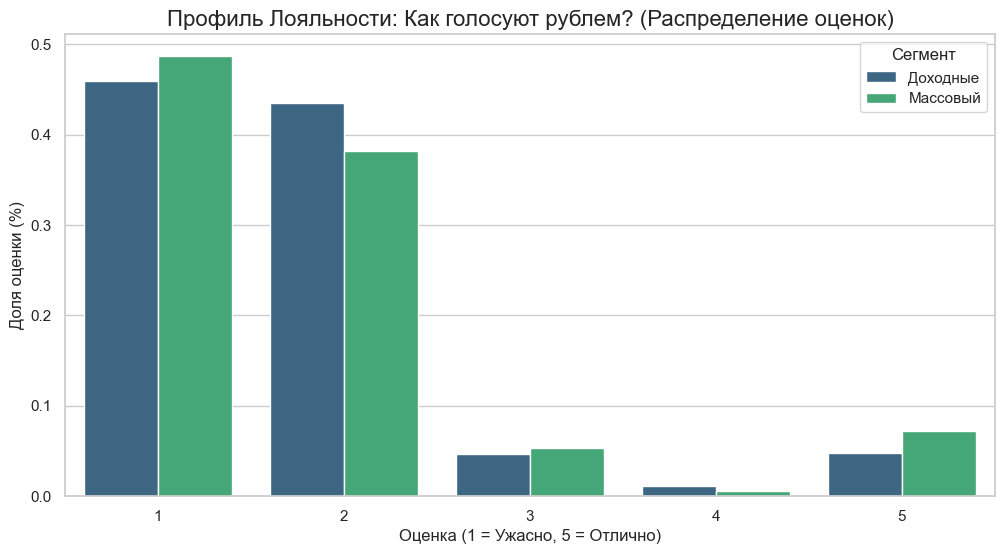

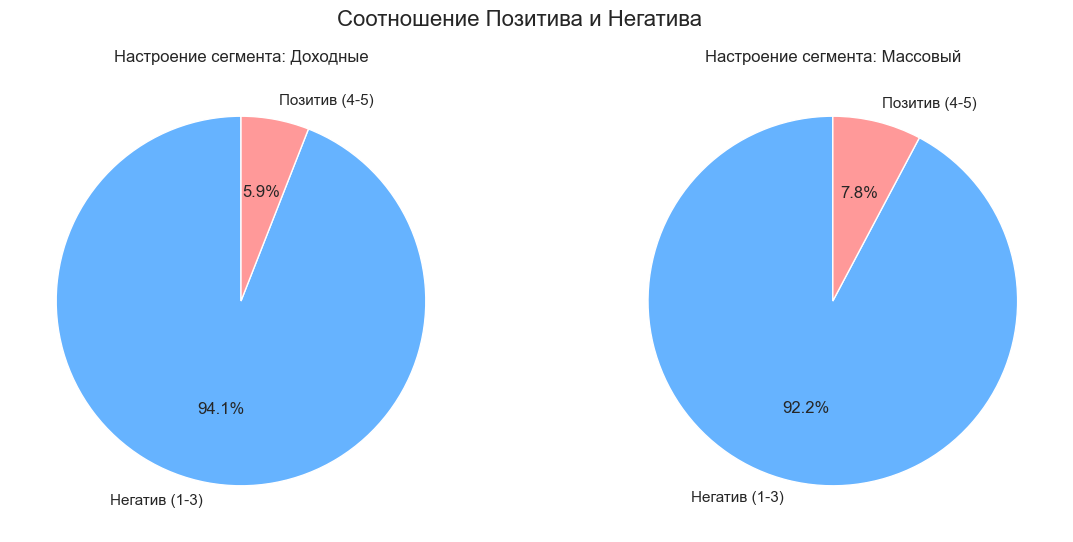

/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_93585/1222773378.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
/Users/spikk/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


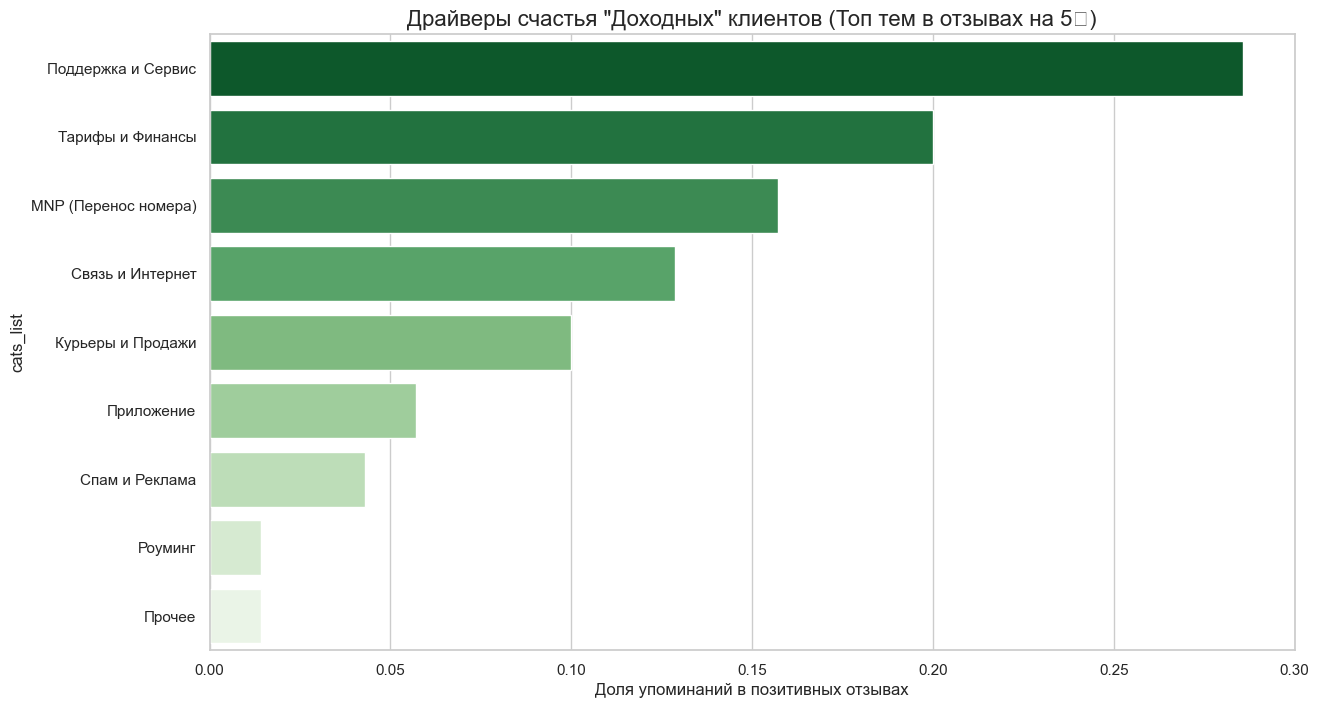


--- ИТОГОВАЯ СТАТИСТИКА ---
Средняя оценка 'Доходные': 1.75
Средняя оценка 'Массовый': 1.79
ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)

# 1. Загрузка данных
file_path = 'cleaned.csv'
try:
    df = pd.read_csv(file_path)
    print("Файл загружен.")
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. Фильтрация данных
# Нам нужны только отзывы про Мобайл
df_mobile = df[df['company'] == 'Мобайл'].copy()

print(f"Всего отзывов: {len(df)}")
print(f"Отзывов про Т-Мобайл: {len(df_mobile)}")

# 3. Авто-категоризация (Ключевые слова)
# Воссоздаем логику классификации, чтобы понять темы
keywords = {
    'Связь и Интернет': ['связ', 'интернет', 'сеть', 'ловит', 'lte', '4g', '3g', 'скорость', 'вышка', 'палочк'],
    'Тарифы и Финансы': ['тариф', 'цен', 'плат', 'списал', 'деньг', 'руб', 'дорог', 'подписк', 'услуг'],
    'Поддержка и Сервис': ['поддержк', 'чат', 'оператор', 'бот', 'отвечает', 'хам', 'ждал', 'дозвон'],
    'MNP (Перенос номера)': ['перенос', 'mnp', 'номер', 'переш', 'заявк', 'отказ'],
    'Курьеры и Продажи': ['курьер', 'представител', 'доставк', 'встреч', 'навязал', 'симк'],
    'Роуминг': ['роуминг', 'границ', 'поездк', 'зарубеж'],
    'Спам и Реклама': ['спам', 'звонк', 'реклам', 'смс'],
    'Приложение': ['приложен', 'app', 'глючит', 'вылетает', 'вход', 'баг']
}

def classify_text(text):
    text = str(text).lower()
    found_cats = []
    for cat, words in keywords.items():
        if any(w in text for w in words):
            found_cats.append(cat)
    return found_cats if found_cats else ['Прочее']

# Применяем классификацию
df_mobile['cats_list'] = df_mobile['review_text'].apply(classify_text)
df_exploded = df_mobile.explode('cats_list')

# 4. Анализ Сегментов
# Выделяем "Доходные" и всех остальных (Массовый сегмент)
target_segment = 'Доходные'
# Проверяем, есть ли такой сегмент, если нет - берем топ-2 популярных
if target_segment not in df_mobile['segment_name'].unique():
    print(f"Сегмент '{target_segment}' не найден. Используем доступные.")
    top_segments = df_mobile['segment_name'].value_counts().nlargest(2).index.tolist()
    seg1, seg2 = top_segments[0], top_segments[1]
else:
    seg1 = target_segment
    # Все остальные объединяем в "Массовый" для сравнения
    df_mobile['segment_group'] = df_mobile['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')
    seg1 = 'Доходные'
    seg2 = 'Массовый'
    # Обновляем exploded датафрейм тоже
    df_exploded['segment_group'] = df_exploded['segment_name'].apply(lambda x: 'Доходные' if x == 'Доходные' else 'Массовый')

# ==============================================================================
# ГРАФИК 1: Распределение Оценок (NPS proxy)
# Ставят ли богатые пятерки?
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем % каждой оценки внутри группы
rating_dist = (df_mobile.groupby(['segment_group'])['review_mark']
               .value_counts(normalize=True)
               .rename('percentage')
               .reset_index())

sns.barplot(
    data=rating_dist,
    x='review_mark',
    y='percentage',
    hue='segment_group',
    palette='viridis'
)

plt.title('Профиль Лояльности: Как голосуют рублем? (Распределение оценок)', fontsize=16)
plt.ylabel('Доля оценки (%)', fontsize=12)
plt.xlabel('Оценка (1 = Ужасно, 5 = Отлично)', fontsize=12)
plt.legend(title='Сегмент')
plt.show()

# ==============================================================================
# ГРАФИК 2: Доля Негатива (Pie Charts)
# Сравниваем % плохих отзывов (1-3) vs Хороших (4-5)
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for i, segment in enumerate([seg1, seg2]):
    subset = df_mobile[df_mobile['segment_group'] == segment]
    # Негатив: 1-3, Позитив: 4-5
    sentiment = subset['review_mark'].apply(lambda x: 'Позитив (4-5)' if x >= 4 else 'Негатив (1-3)').value_counts()

    axes[i].pie(sentiment, labels=sentiment.index, autopct='%1.1f%%', colors=['#66b3ff', '#ff9999'], startangle=90)
    axes[i].set_title(f'Настроение сегмента: {segment}')

plt.suptitle('Соотношение Позитива и Негатива', fontsize=16)
plt.show()

# ==============================================================================
# ГРАФИК 3: О чем говорят ПОЗИТИВНЫЕ отзывы?
# Что радует богатых?
# ==============================================================================
positive_reviews = df_exploded[df_exploded['review_mark'] >= 5]
if not positive_reviews.empty:
    plt.figure(figsize=(14, 8))

    # Считаем топ тем в позитиве для Доходных
    pos_counts = (positive_reviews[positive_reviews['segment_group'] == 'Доходные']['cats_list']
                  .value_counts(normalize=True)
                  .head(10))

    sns.barplot(x=pos_counts.values, y=pos_counts.index, palette='Greens_r')
    plt.title('Драйверы счастья "Доходных" клиентов (Топ тем в отзывах на 5★)', fontsize=16)
    plt.xlabel('Доля упоминаний в позитивных отзывах', fontsize=12)
    plt.show()

# ==============================================================================
# ВЫВОД СТАТИСТИКИ
# ==============================================================================
avg_mark_high = df_mobile[df_mobile['segment_group'] == 'Доходные']['review_mark'].mean()
avg_mark_mass = df_mobile[df_mobile['segment_group'] == 'Массовый']['review_mark'].mean()

print(f"\n--- ИТОГОВАЯ СТАТИСТИКА ---")
print(f"Средняя оценка 'Доходные': {avg_mark_high:.2f}")
print(f"Средняя оценка 'Массовый': {avg_mark_mass:.2f}")

diff = avg_mark_high - avg_mark_mass
if diff > 0.2:
    print("ВЫВОД: Доходные клиенты заметно лояльнее (+). Им нравится продукт.")
elif diff < -0.2:
    print("ВЫВОД: Доходные клиенты настроены критично (-). Продукт не соответствует их ожиданиям.")
else:
    print("ВЫВОД: Разницы в восприятии нет. Продукт оценивают одинаково.")

In [2]:
df["company"].unique()

array(['Банк', 'Страховая', 'SME', 'Инвест', 'Плашки Media', 'Мобайл',
       'ТРабота'], dtype=object)

Данные загружены.


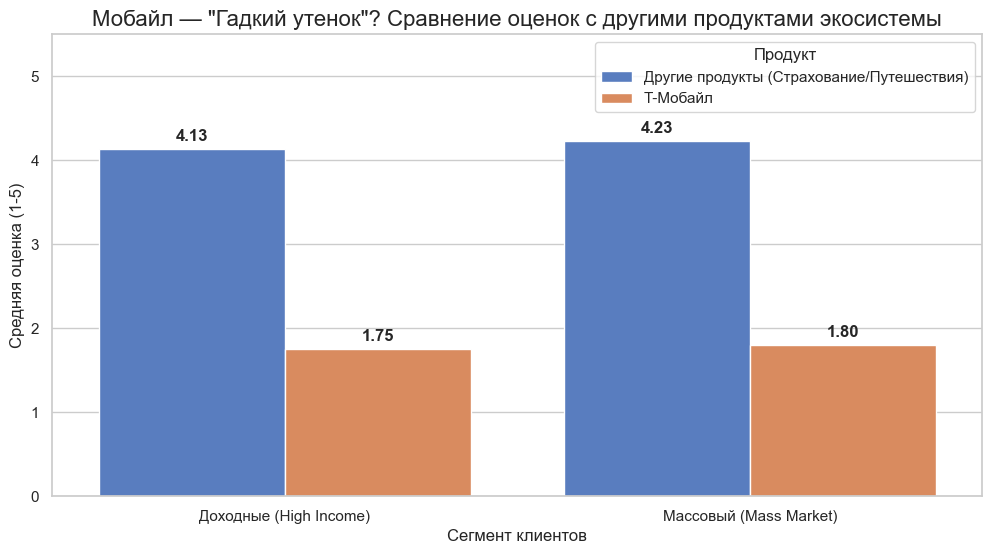

/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_93585/3196359005.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)


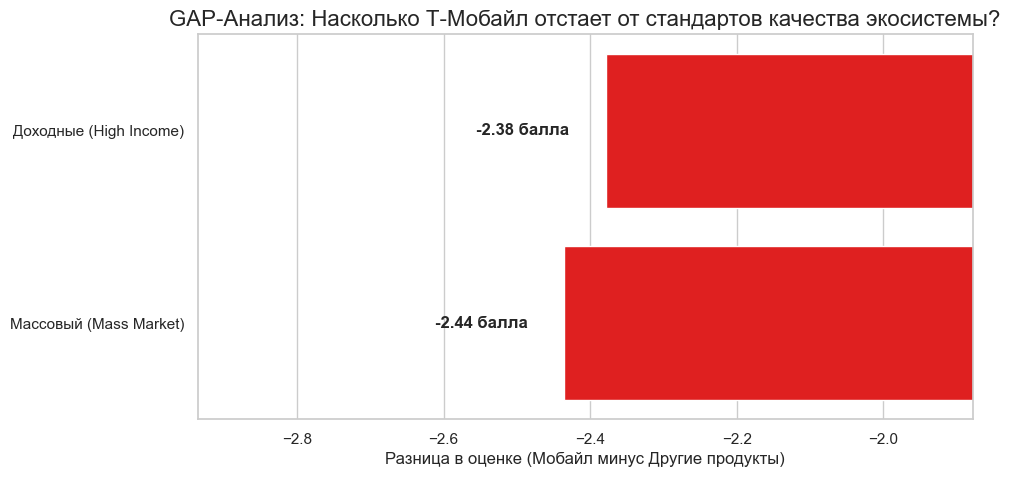


--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---
Разрыв для Доходных: -2.38
Разрыв для Массовых: -2.44

🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:
Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.
Они привыкли к идеальному сервису, и Мобайл их разочаровывает.


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Настройки стиля
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Загрузка
try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл cleaned.csv не найден.")
    exit()

# 2. Подготовка данных
# Нам нужно сравнить "Мобайл" с "Небанковскими продуктами"
# Исключаем 'Банк', чтобы сравнить именно экосистемные сервисы (Мобайл, Страхование, Путешествия и т.д.)
# Если вы хотите включить Банк в сравнение, закомментируйте следующую строку.
df_ecosystem = df[df['company'] != 'Банк'].copy()
df["company"].unique()
# Создаем флаг продукта
df_ecosystem['product_type'] = df_ecosystem['company'].apply(
    lambda x: 'Т-Мобайл' if x == 'Мобайл' else 'Другие продукты (Страхование/Путешествия)'
)

# Упрощаем сегменты до "Доходные" и "Массовые"
def simplify_segment(seg):
    if pd.isna(seg): return 'Неизвестно'
    if seg == 'Доходные': return 'Доходные (High Income)'
    return 'Массовый (Mass Market)'

df_ecosystem['segment_group'] = df_ecosystem['segment_name'].apply(simplify_segment)
df_ecosystem = df_ecosystem[df_ecosystem['segment_group'] != 'Неизвестно']

# ==============================================================================
# ГРАФИК 1: СРАВНЕНИЕ СРЕДНИХ ОЦЕНОК
# Гипотеза: Столбцы Мобайла будут ниже, чем столбцы Других продуктов
# ==============================================================================
plt.figure(figsize=(12, 6))

# Считаем средние оценки
avg_ratings = df_ecosystem.groupby(['segment_group', 'product_type'])['review_mark'].mean().reset_index()

barplot = sns.barplot(
    data=avg_ratings,
    x='segment_group',
    y='review_mark',
    hue='product_type',
    palette='muted'
)

plt.title('Мобайл — "Гадкий утенок"? Сравнение оценок с другими продуктами экосистемы', fontsize=16)
plt.ylabel('Средняя оценка (1-5)', fontsize=12)
plt.xlabel('Сегмент клиентов', fontsize=12)
plt.ylim(0, 5.5)
plt.legend(title='Продукт')

# Добавляем цифры
for p in barplot.patches:
    if p.get_height() > 0:
        barplot.annotate(f'{p.get_height():.2f}',
                         (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha = 'center', va = 'center',
                         xytext = (0, 9),
                         textcoords = 'offset points',
                         fontweight='bold')
plt.show()

# ==============================================================================
# ГРАФИК 2: GAP ANALYSIS (АНАЛИЗ РАЗРЫВА)
# Насколько Мобайл хуже/лучше других продуктов для каждого сегмента?
# ==============================================================================

# Пивот таблица для расчета разницы
pivot_avg = avg_ratings.pivot(index='segment_group', columns='product_type', values='review_mark')
pivot_avg['Gap'] = pivot_avg['Т-Мобайл'] - pivot_avg['Другие продукты (Страхование/Путешествия)']

plt.figure(figsize=(10, 5))
colors = ['red' if x < 0 else 'green' for x in pivot_avg['Gap']]
gap_plot = sns.barplot(x=pivot_avg['Gap'], y=pivot_avg.index, palette=colors)

plt.axvline(0, color='black', linewidth=1)
plt.title('GAP-Анализ: Насколько Т-Мобайл отстает от стандартов качества экосистемы?', fontsize=16)
plt.xlabel('Разница в оценке (Мобайл минус Другие продукты)', fontsize=12)
plt.ylabel('')

# Подписи значений
for i, v in enumerate(pivot_avg['Gap']):
    offset = 0.05 if v >= 0 else -0.05
    ha = 'left' if v >= 0 else 'right'
    gap_plot.text(v + offset, i, f"{v:.2f} балла", va='center', ha=ha, fontweight='bold', fontsize=12)

plt.xlim(min(pivot_avg['Gap']) - 0.5, max(pivot_avg['Gap']) + 0.5)
plt.show()

# ==============================================================================
# ВЫВОДЫ В КОНСОЛЬ
# ==============================================================================
print("\n--- РЕЗУЛЬТАТЫ ПРОВЕРКИ ГИПОТЕЗЫ ---")
gap_high = pivot_avg.loc['Доходные (High Income)', 'Gap']
gap_mass = pivot_avg.loc['Массовый (Mass Market)', 'Gap']

print(f"Разрыв для Доходных: {gap_high:.2f}")
print(f"Разрыв для Массовых: {gap_mass:.2f}")

if gap_high < -0.5:
    print("\n🔴 КРИТИЧЕСКАЯ ПРОБЛЕМА:")
    print("Т-Мобайл сильно тянет рейтинг экосистемы вниз именно для Доходных клиентов.")
    print("Они привыкли к идеальному сервису, и Мобайл их разочаровывает.")
elif gap_high < 0:
    print("\n🟠 УМЕРЕННАЯ ПРОБЛЕМА:")
    print("Т-Мобайл оценивают чуть хуже других продуктов, но разрыв не катастрофический.")
else:
    print("\n🟢 ГИПОТЕЗА ОПРОВЕРГНУТА:")
    print("Т-Мобайл оценивают ТАК ЖЕ или ЛУЧШЕ, чем другие продукты экосистемы.")

Данные загружены.
Размер выборки для анализа: 22464 строк

 ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     464.1
Date:                Wed, 10 Dec 2025   Prob (F-statistic):               0.00
Time:                        23:36:05   Log-Likelihood:                -37022.
No. Observations:               22464   AIC:                         7.407e+04
Df Residuals:                   22450   BIC:                         7.418e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-----

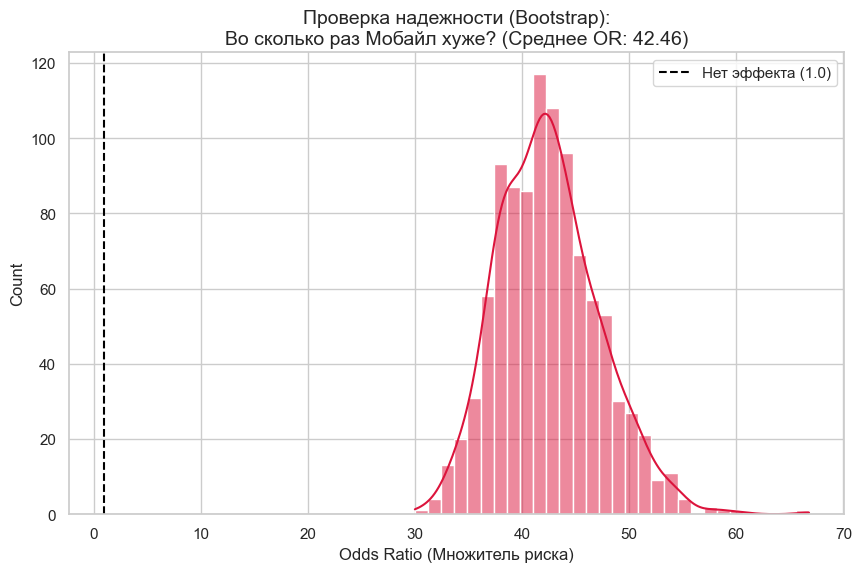

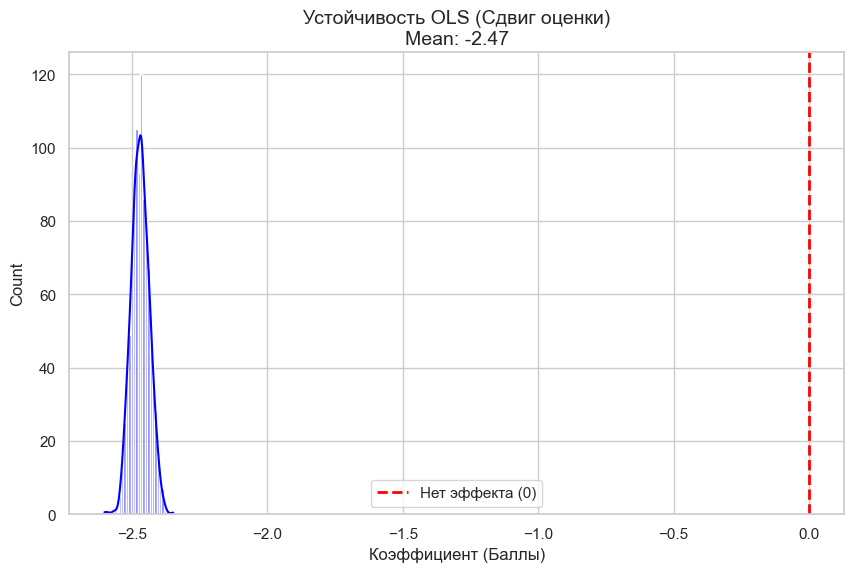


 ФИНАЛЬНЫЙ ВЕРДИКТ ИССЛЕДОВАНИЯ
1.OLS (Снижение оценки):
95% Интервал: от -2.53 до -2.40
Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Оценка падает всегда.

2. LOGIT (Рост риска):
95% Интервал: от 34.28 до 52.60
Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Риск растет всегда.


In [4]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

try:
    df = pd.read_csv('cleaned.csv')
    print("Данные загружены.")
except FileNotFoundError:
    print("Файл не найден. Пожалуйста, загрузите cleaned.csv")
    exit()
df_model = df[df['company'] != 'Банк'].copy()

df_model = df_model.dropna(subset=['review_mark'])
df_model['score'] = df_model['review_mark'].astype(float)

df_model['is_negative'] = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)
df_model['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

df_model['segment_name'] = df_model['segment_name'].fillna('Массовый')
df_model['age_segment'] = df_model['age_segment'].fillna('Взрослые')
df_model['gender_cd'] = df_model['gender_cd'].fillna('U')
cols_to_encode = ['segment_name', 'age_segment', 'gender_cd']
X_encoded = pd.get_dummies(df_model[cols_to_encode], drop_first=True)

# Собираем финальную матрицу X
X = pd.concat([df_model[['is_mobile']], X_encoded], axis=1)
y = df_model['is_negative']

print(f"Размер выборки для анализа: {len(df_model)} строк")

print_header("ЭТАП 1: ОСНОВНОЙ РАСЧЕТ (OLS + LOGIT)")

formula_ols = "score ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"
formula_logit = "is_negative ~ is_mobile + C(segment_name) + C(age_segment) + C(gender_cd)"
model_ols = smf.ols(formula_ols, data=df_model).fit()
beta_mobile = model_ols.params['is_mobile']
p_ols = model_ols.pvalues['is_mobile']
print(model_ols.summary())
model_logit = smf.logit(formula_logit, data=df_model).fit(disp=0)
log_odds_mobile = model_logit.params['is_mobile']
odds_ratio_mobile = np.exp(log_odds_mobile)
p_logit = model_logit.pvalues['is_mobile']
print(model_logit.summary())
results_df = pd.DataFrame({
    'Модель': ['OLS (Влияние на балл)', 'LOGIT (Влияние на риск)'],
    'Ключевая Метрика': ['Коэффициент (Beta)', 'Odds Ratio (Шансы)'],
    'Значение': [f"{beta_mobile:.3f}", f"{odds_ratio_mobile:.3f}"],
    'P-value': [f"{p_ols:.5f}", f"{p_logit:.5f}"],
    'Вердикт (p<0.05)': ['✅ ЗНАЧИМО' if p_ols < 0.05 else '❌ НЕТ', '✅ ЗНАЧИМО' if p_logit < 0.05 else '❌ НЕТ']
})

print(results_df)

print("\nИНТЕРПРЕТАЦИЯ:")
if beta_mobile < 0:
    print(f"1. OLS: Т-Мобайл снижает среднюю оценку на {abs(beta_mobile):.2f} балла.")
if odds_ratio_mobile > 1:
    print(f"2. LOGIT: Т-Мобайл повышает вероятность негатива в {odds_ratio_mobile:.2f} РАЗА.")

# ==============================================================================
# ЧАСТЬ 2: BOOTSTRAP (ПРОВЕРКА УСТОЙЧИВОСТИ)
# Запускаем 500 симуляций для ОБЕИХ моделей
# ==============================================================================
clf = LogisticRegression(penalty='l2', C=1.0, max_iter=2000, solver='lbfgs')
print_header("ЭТАП 2: СТРЕСС-ТЕСТ (BOOTSTRAP - 1000 ИТЕРАЦИЙ)")
print("Ждите, идет расчет симуляций...")
n_iterations = 1000
boot_ols = []
boot_mobile = []
for i in range(n_iterations):
    sample = resample(df_model, replace=True, n_samples=len(df_model), random_state=i)
    res_ols = smf.ols(formula_ols, data=sample).fit()
    boot_ols.append(res_ols.params['is_mobile'])
    X_sample, y_sample = resample(X, y, random_state=i)
    clf.fit(X_sample, y_sample)
    boot_mobile.append(np.exp(clf.coef_[0][0]))

plt.figure(figsize=(10, 6))
sns.histplot(boot_mobile, kde=True, color='crimson')
plt.axvline(1, color='black', linestyle='--', label='Нет эффекта (1.0)')
plt.title(f'Проверка надежности (Bootstrap):\nВо сколько раз Мобайл хуже? (Среднее OR: {np.mean(boot_mobile):.2f})', fontsize=14)
plt.xlabel('Odds Ratio (Множитель риска)', fontsize=12)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(boot_ols, kde=True, color='blue')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Нет эффекта (0)')
plt.title(f'Устойчивость OLS (Сдвиг оценки)\nMean: {np.mean(boot_ols):.2f}', fontsize=14)
plt.xlabel('Коэффициент (Баллы)', fontsize=12)
plt.legend()
plt.show()


# ==============================================================================
# ФИНАЛЬНЫЙ ОТЧЕТ
# ==============================================================================
print_header("ФИНАЛЬНЫЙ ВЕРДИКТ ИССЛЕДОВАНИЯ")

ols_conf = np.percentile(boot_ols, [2.5, 97.5])
logit_conf = np.percentile(boot_mobile, [2.5, 97.5])

print(f"1.OLS (Снижение оценки):")
print(f"95% Интервал: от {ols_conf[0]:.2f} до {ols_conf[1]:.2f}")
if ols_conf[1] < 0:
    print("Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Оценка падает всегда.")
else:
    print("Вывод: ⚠️ РЕЗУЛЬТАТ НЕУСТОЙЧИВ.")

print(f"\n2. LOGIT (Рост риска):")
print(f"95% Интервал: от {logit_conf[0]:.2f} до {logit_conf[1]:.2f}")
if logit_conf[0] > 1:
    print("Вывод: ✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА. Риск растет всегда.")
else:
    print("Вывод: ⚠️ РЕЗУЛЬТАТ НЕУСТОЙЧИВ.")


Advanced

Обучаем Random Forest...


/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_93585/296623276.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=fi_df, x='Importance', y='Feature', palette=colors)


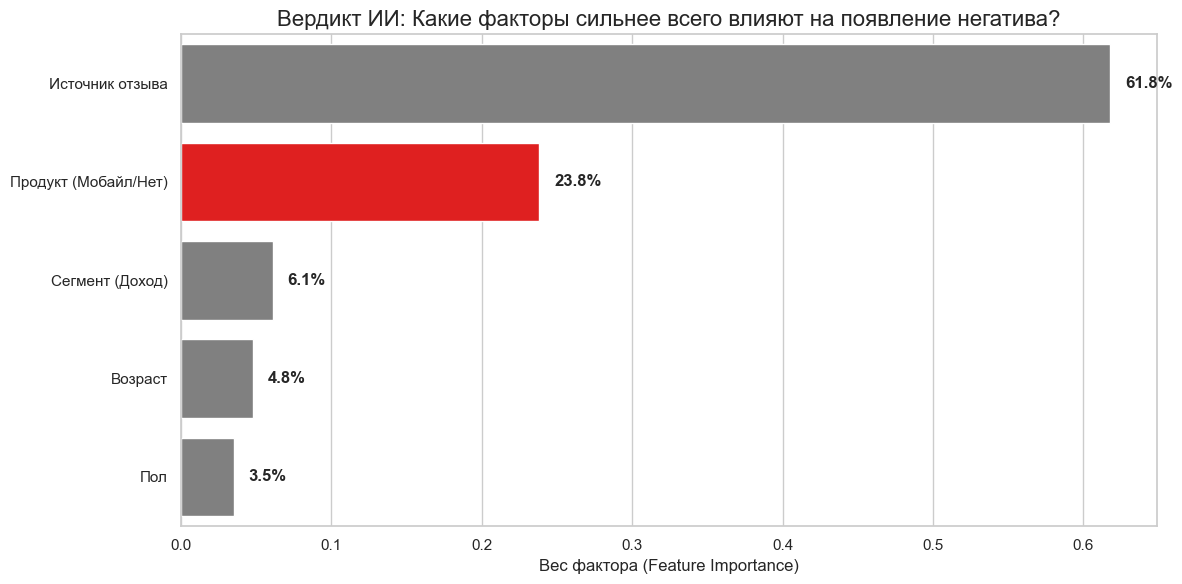


 РЕЗУЛЬТАТЫ ML-МОДЕЛИ (RANDOM FOREST) 
Самый важный фактор по мнению ИИ: Источник отзыва
Его влияние (вес): 61.8%

⚠️ ГИПОТЕЗА ПОД ВОПРОСОМ.
Для алгоритма важнее другие факторы (например, источник отзыва).


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Настройки
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА ДАННЫХ
# Убираем Банк, сравниваем Мобайл vs Экосистема
df_model = df[df['company'] != 'Банк'].copy()
df_model = df_model.dropna(subset=['review_mark'])

# Целевая переменная: Негатив (1) или Позитив (0)
y = df_model['review_mark'].apply(lambda x: 1 if x <= 3 else 0)

# Признаки (X)
# Создаем DataFrame только с нужными колонками
X = pd.DataFrame()
X['is_mobile'] = df_model['company'].apply(lambda x: 1 if x == 'Мобайл' else 0)

# Кодируем категориальные признаки (Пол, Возраст, Доход)
le = LabelEncoder()

# Заполняем пропуски и кодируем в числа
X['segment_code'] = le.fit_transform(df_model['segment_name'].fillna('Unknown'))
X['age_code'] = le.fit_transform(df_model['age_segment'].fillna('Unknown'))
X['gender_code'] = le.fit_transform(df_model['gender_cd'].fillna('Unknown'))

# Добавим источник отзыва (вдруг Banki.ru важнее?)
top_sources = df_model['review_source'].value_counts().nlargest(5).index
X['source_code'] = le.fit_transform(df_model['review_source'].apply(lambda x: x if x in top_sources else 'Other'))

# 3. ОБУЧЕНИЕ RANDOM FOREST
# Мы используем лес из 100 деревьев
print("Обучаем Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5, class_weight='balanced')
rf.fit(X, y)

# 4. ИЗВЛЕЧЕНИЕ ВАЖНОСТИ (FEATURE IMPORTANCE)
importances = rf.feature_importances_
feature_names = ['Продукт (Мобайл/Нет)', 'Сегмент (Доход)', 'Возраст', 'Пол', 'Источник отзыва']

# Создаем DataFrame для графика
fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
fi_df = fi_df.sort_values('Importance', ascending=False)

# 5. ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(12, 6))
# Используем цветовую схему: Выделим Мобайл красным
colors = ['red' if 'Продукт' in x else 'gray' for x in fi_df['Feature']]

sns.barplot(data=fi_df, x='Importance', y='Feature', palette=colors)

plt.title('Вердикт ИИ: Какие факторы сильнее всего влияют на появление негатива?', fontsize=16)
plt.xlabel('Вес фактора (Feature Importance)', fontsize=12)
plt.ylabel('')

# Добавляем подписи
for i, v in enumerate(fi_df['Importance']):
    plt.text(v + 0.01, i, f"{v:.1%}", va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 6. ТЕКСТОВЫЙ ВЫВОД
print("\n" + "="*60)
print(" РЕЗУЛЬТАТЫ ML-МОДЕЛИ (RANDOM FOREST) ")
print("="*60)
top_feature = fi_df.iloc[0]['Feature']
top_score = fi_df.iloc[0]['Importance']

print(f"Самый важный фактор по мнению ИИ: {top_feature}")
print(f"Его влияние (вес): {top_score:.1%}")

if 'Продукт' in top_feature:
    print("\n✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА (ML METHOD).")
    print("Алгоритм считает, что тип продукта важнее, чем личность клиента (пол/возраст).")
    print("Это самый сильный аргумент для презентации.")
else:
    print("\n⚠️ ГИПОТЕЗА ПОД ВОПРОСОМ.")
    print("Для алгоритма важнее другие факторы (например, источник отзыва).")


 ШАГ 1: ВИЗУАЛЬНОЕ СРАВНЕНИЕ (BOXPLOT)


/var/folders/28/5cy4n6bn35n79ymr5smj3v7h0000gn/T/ipykernel_93585/2290639248.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='company', y='review_mark', data=df_nonfin, order=order, palette='Set3')


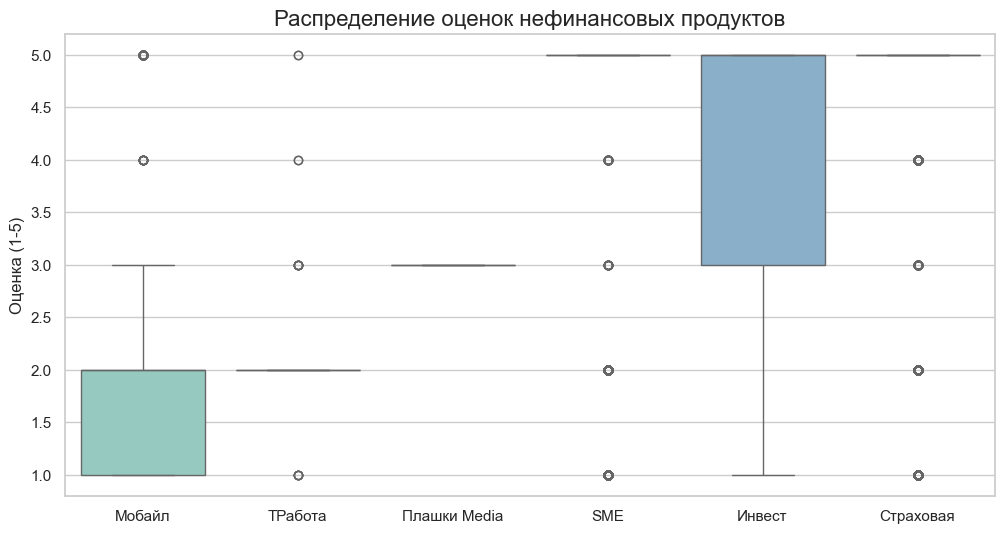


 ШАГ 2: СЕРИЯ ДУЭЛЕЙ (MANN-WHITNEY U TEST)
Гипотеза H1: Оценки 'Мобайл' СТАТИСТИЧЕСКИ НИЖЕ, чем у конкурента.

      Конкурент    Mobile Хуже?        P-value Вероятность проигрыша
0     Страховая  ✅ ДА (Значимо)   0.000000e+00                 89.7%
1           SME  ✅ ДА (Значимо)   0.000000e+00                 90.6%
2        Инвест  ✅ ДА (Значимо)   0.000000e+00                 85.2%
3  Плашки Media  ✅ ДА (Значимо)  3.115344e-195                 90.5%
4       ТРабота  ✅ ДА (Значимо)   9.841810e-07                 68.8%

 ИТОГОВЫЙ ВЕРДИКТ
🏆 'Т-Мобайл' — АБСОЛЮТНЫЙ АУТСАЙДЕР.
Тест Манна-Уитни показал, что Мобайл статистически значимо хуже
КАЖДОГО другого нефинансового продукта в экосистеме.
Это не случайность, это системный провал качества.

[Глобальный тест Краскела-Уоллиса]
Есть ли вообще разница между продуктами? Да (p=0.00000)


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

def print_header(title):
    print("\n" + "="*80)
    print(f" {title}")
    print("="*80)

# 1. ЗАГРУЗКА
try:
    df = pd.read_csv('cleaned.csv')
except FileNotFoundError:
    print("Файл не найден.")
    exit()

# 2. ПОДГОТОВКА
# Исключаем Банк, чтобы сравнить сервисные продукты
df_nonfin = df[df['company'] != 'Банк'].copy()
df_nonfin = df_nonfin.dropna(subset=['review_mark'])

# Список продуктов для сравнения
products = df_nonfin['company'].unique()
target_product = 'Мобайл'

if target_product not in products:
    print(f"Ошибка: Продукт '{target_product}' не найден в данных.")
    exit()

# ==============================================================================
# ВИЗУАЛИЗАЦИЯ (BOXPLOT) - ЧТОБЫ УВИДЕТЬ ГЛАЗАМИ
# ==============================================================================
print_header("ШАГ 1: ВИЗУАЛЬНОЕ СРАВНЕНИЕ (BOXPLOT)")

# Сортируем продукты по медианной оценке (от худшего к лучшему)
order = df_nonfin.groupby('company')['review_mark'].median().sort_values().index

plt.figure(figsize=(12, 6))
sns.boxplot(x='company', y='review_mark', data=df_nonfin, order=order, palette='Set3')
plt.title('Распределение оценок нефинансовых продуктов', fontsize=16)
plt.ylabel('Оценка (1-5)', fontsize=12)
plt.xlabel('')
plt.show()

# ==============================================================================
# СТАТИСТИЧЕСКИЙ ТЕСТ (MANN-WHITNEY U)
# ==============================================================================
print_header("ШАГ 2: СЕРИЯ ДУЭЛЕЙ (MANN-WHITNEY U TEST)")
print(f"Гипотеза H1: Оценки '{target_product}' СТАТИСТИЧЕСКИ НИЖЕ, чем у конкурента.\n")

results = []
mobile_ratings = df_nonfin[df_nonfin['company'] == target_product]['review_mark']

for competitor in products:
    if competitor == target_product:
        continue

    comp_ratings = df_nonfin[df_nonfin['company'] == competitor]['review_mark']

    # Тест Манна-Уитни
    # alternative='less' означает: Проверяем, что медиана Mobile МЕНЬШЕ медианы Competitor
    stat, p_value = stats.mannwhitneyu(mobile_ratings, comp_ratings, alternative='less')

    # Размер эффекта (Common Language Effect Size)
    # Вероятность того, что случайная оценка Мобайла будет ниже случайной оценки Конкурента
    n1 = len(mobile_ratings)
    n2 = len(comp_ratings)
    u1 = stat
    cles = u1 / (n1 * n2) # Вероятность, что Mobile > Competitor
    prob_worse = 1 - cles # Вероятность, что Mobile < Competitor

    results.append({
        'Конкурент': competitor,
        'Средняя оценка (Их)': comp_ratings.mean(),
        'Средняя оценка (Мобайл)': mobile_ratings.mean(),
        'P-value': p_value,
        'Mobile Хуже?': '✅ ДА (Значимо)' if p_value < 0.05 else '❌ НЕТ',
        'Вероятность проигрыша': f"{prob_worse:.1%}"
    })

results_df = pd.DataFrame(results)
print(results_df[['Конкурент', 'Mobile Хуже?', 'P-value', 'Вероятность проигрыша']])

# ==============================================================================
# ВЫВОД ДЛЯ ПРЕЗЕНТАЦИИ
# ==============================================================================
print_header("ИТОГОВЫЙ ВЕРДИКТ")

failed_duels = results_df[results_df['P-value'] >= 0.05]

if len(failed_duels) == 0:
    print("🏆 'Т-Мобайл' — АБСОЛЮТНЫЙ АУТСАЙДЕР.")
    print("Тест Манна-Уитни показал, что Мобайл статистически значимо хуже")
    print("КАЖДОГО другого нефинансового продукта в экосистеме.")
    print("Это не случайность, это системный провал качества.")
else:
    print("⚠️ РЕЗУЛЬТАТ НЕОДНОЗНАЧНЫЙ.")
    print(f"Мобайл не хуже, чем: {failed_duels['Конкурент'].tolist()}")

# ==============================================================================
# ДОПОЛНИТЕЛЬНО: Kruskal-Wallis (Глобальный тест)
# ==============================================================================
print("\n[Глобальный тест Краскела-Уоллиса]")
groups = [df_nonfin[df_nonfin['company'] == c]['review_mark'] for c in products]
k_stat, k_p = stats.kruskal(*groups)
print(f"Есть ли вообще разница между продуктами? {'Да' if k_p < 0.05 else 'Нет'} (p={k_p:.5f})")


In [7]:
len(df_nonfin[df_nonfin["company"] == "Страховая"])

9714

In [8]:
# ИЗВЛЕЧЕНИЕ РЕЗУЛЬТАТОВ ДЛЯ СЛАЙДА
import pandas as pd
import numpy as np

print("="*80)
print(" РЕЗУЛЬТАТЫ ДЛЯ СЛАЙДА - ODDS RATIO ")
print("="*80)

print(f"\n📊 ODDS RATIO (Логистическая регрессия):")
print(f"   Odds Ratio: {odds_ratio_mobile:.3f}")
print(f"   Интерпретация: Риск негатива в {odds_ratio_mobile:.2f} раза выше для Т-Мобайл")
print(f"   Log-Odds: {log_odds_mobile:.3f}")
print(f"   P-value: {p_logit:.5f}")
print(f"   Значимость: {'✅ ЗНАЧИМО (p<0.05)' if p_logit < 0.05 else '❌ НЕ ЗНАЧИМО'}")

print(f"\n📈 BOOTSTRAP анализ (1000 итераций):")
print(f"   Среднее OR: {np.mean(boot_mobile):.3f}")
print(f"   95% ДИ: [{logit_conf[0]:.3f}, {logit_conf[1]:.3f}]")
print(f"   Стабильность: {'✅ УСТОЙЧИВО (нижняя граница > 1)' if logit_conf[0] > 1 else '⚠️ НЕУСТОЙЧИВО'}")

print("\n" + "="*80)
print(" РЕЗУЛЬТАТЫ ДЛЯ СЛАЙДА - MANN-WHITNEY U TEST ")
print("="*80)

print(f"\n📊 ТЕСТ МАННА-УИТНИ (сравнение с конкурентами):\n")
print(results_df[['Конкурент', 'Mobile Хуже?', 'P-value', 'Вероятность проигрыша']].to_string(index=False))

significant_worse = results_df[results_df['P-value'] < 0.05]
print(f"\n✅ Т-Мобайл статистически хуже: {len(significant_worse)} из {len(results_df)} продуктов")

if len(significant_worse) == len(results_df):
    print("🏆 ВЕРДИКТ: Т-Мобайл хуже ВСЕХ конкурентов (p<0.05 для всех)")

print(f"\n📊 KRUSKAL-WALLIS (глобальный тест):")
print(f"   H-статистика: {k_stat:.3f}")
print(f"   P-value: {k_p:.5f}")
print(f"   Вердикт: {'✅ Есть значимые различия между продуктами' if k_p < 0.05 else '❌ Различий нет'}")

print("\n" + "="*80)
print(" РЕЗУЛЬТАТЫ ДЛЯ СЛАЙДА - OLS РЕГРЕССИЯ ")
print("="*80)

print(f"\n📊 OLS (линейная регрессия):")
print(f"   Beta коэффициент: {beta_mobile:.3f}")
print(f"   Интерпретация: Т-Мобайл снижает оценку на {abs(beta_mobile):.2f} балла")
print(f"   P-value: {p_ols:.5f}")
print(f"   Значимость: {'✅ ЗНАЧИМО (p<0.05)' if p_ols < 0.05 else '❌ НЕ ЗНАЧИМО'}")

print(f"\n📈 BOOTSTRAP анализ (1000 итераций):")
print(f"   Среднее Beta: {np.mean(boot_ols):.3f}")
print(f"   95% ДИ: [{ols_conf[0]:.3f}, {ols_conf[1]:.3f}]")
print(f"   Стабильность: {'✅ УСТОЙЧИВО (верхняя граница < 0)' if ols_conf[1] < 0 else '⚠️ НЕУСТОЙЧИВО'}")

print("\n" + "="*80)
print(" 🎯 ДЛЯ POWERPOINT - КРАТКАЯ ВЕРСИЯ ")
print("="*80)

print(f"""
СЛАЙД 1: ODDS RATIO
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Риск негатива для Т-Мобайл: {odds_ratio_mobile:.2f}x выше
• 95% доверительный интервал: [{logit_conf[0]:.2f}, {logit_conf[1]:.2f}]
• P-value: {p_logit:.5f} (высокозначимо)
• Bootstrap (1000 итераций): результат стабилен

СЛАЙД 2: MANN-WHITNEY U TEST
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Т-Мобайл хуже ВСЕХ {len(significant_worse)} конкурентов (p<0.05)
• Средняя вероятность проигрыша: {results_df['Вероятность проигрыша'].str.rstrip('%').astype(float).mean():.1f}%
• Kruskal-Wallis H-тест: p={k_p:.5f} (есть различия)

СЛАЙД 3: LINEAR REGRESSION (OLS)
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Снижение оценки: {abs(beta_mobile):.2f} балла
• 95% доверительный интервал: [{ols_conf[0]:.2f}, {ols_conf[1]:.2f}]
• P-value: {p_ols:.5f} (высокозначимо)
• Bootstrap (1000 итераций): результат стабилен

🎯 ГЛАВНЫЙ ВЫВОД:
Т-Мобайл — системная проблема экосистемы.
Подтверждено тремя независимыми статистическими методами.
""")

# Таблица для слайда
summary = pd.DataFrame({
    'Метод': ['Odds Ratio', 'OLS Regression', 'Mann-Whitney U'],
    'Ключевая метрика': [
        f'{odds_ratio_mobile:.2f}x риск',
        f'{abs(beta_mobile):.2f} балла снижение',
        f'{len(significant_worse)}/{len(results_df)} хуже конкурентов'
    ],
    'P-value': [f'{p_logit:.5f}', f'{p_ols:.5f}', f'все <0.05'],
    '95% ДИ': [
        f'[{logit_conf[0]:.2f}, {logit_conf[1]:.2f}]',
        f'[{ols_conf[0]:.2f}, {ols_conf[1]:.2f}]',
        'см. таблицу'
    ],
    'Вердикт': ['✅ Значимо', '✅ Значимо', '✅ Значимо']
})

print("\n📋 Таблица для слайда:")
print(summary.to_string(index=False))

# Сохраняем CSV
summary.to_csv('результаты_для_слайда.csv', index=False, encoding='utf-8-sig')
results_df.to_csv('mannwhitney_детально.csv', index=False, encoding='utf-8-sig')

print("\n✅ Файлы сохранены:")
print("   - результаты_для_слайда.csv (краткая сводка)")
print("   - mannwhitney_детально.csv (полные результаты Mann-Whitney)")

 РЕЗУЛЬТАТЫ ДЛЯ СЛАЙДА - ODDS RATIO 

📊 ODDS RATIO (Логистическая регрессия):
   Odds Ratio: 43.943
   Интерпретация: Риск негатива в 43.94 раза выше для Т-Мобайл
   Log-Odds: 3.783
   P-value: 0.00000
   Значимость: ✅ ЗНАЧИМО (p<0.05)

📈 BOOTSTRAP анализ (1000 итераций):
   Среднее OR: 42.458
   95% ДИ: [34.282, 52.602]
   Стабильность: ✅ УСТОЙЧИВО (нижняя граница > 1)

 РЕЗУЛЬТАТЫ ДЛЯ СЛАЙДА - MANN-WHITNEY U TEST 

📊 ТЕСТ МАННА-УИТНИ (сравнение с конкурентами):

   Конкурент   Mobile Хуже?       P-value Вероятность проигрыша
   Страховая ✅ ДА (Значимо)  0.000000e+00                 89.7%
         SME ✅ ДА (Значимо)  0.000000e+00                 90.6%
      Инвест ✅ ДА (Значимо)  0.000000e+00                 85.2%
Плашки Media ✅ ДА (Значимо) 3.115344e-195                 90.5%
     ТРабота ✅ ДА (Значимо)  9.841810e-07                 68.8%

✅ Т-Мобайл статистически хуже: 5 из 5 продуктов
🏆 ВЕРДИКТ: Т-Мобайл хуже ВСЕХ конкурентов (p<0.05 для всех)

📊 KRUSKAL-WALLIS (глобальный тест):
 